In [1]:
import numpy as np

#self written libraries
from model_builder import ModelBuild
from data_prep import DataPrep
from lime_evaluator import Lime_eval

#other libraries
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# pandas concat in lime_evaluator

In [2]:
data_location = "./data/compas-scores-two-years.csv"
compas_score_full = pd.read_csv(data_location)
data_prepper = DataPrep(compas_score_full)
X, y, X_cols = data_prepper.get()

features = [c for c in X]

categorical_feature_name = ['two_year_recid', 'c_charge_degree_F', 'c_charge_degree_M',\
                            'sex_Female', 'sex_Male', 'race']

categorical_feature_indcs = [features.index(c) for c in categorical_feature_name]
race_indc = features.index('race')

X=X.to_numpy()
#make all columns float
X = X.astype(float)
y=np.array(y)

Accuracy: 0.7643724696356275


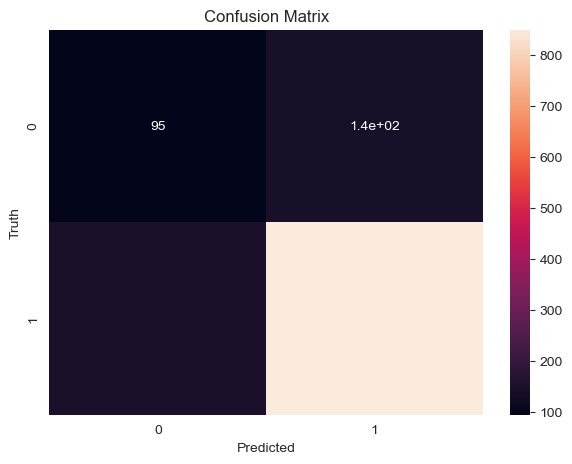

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=32, shuffle=True)
modelBuilder = ModelBuild('DecisionTree')
model, accuracy, cm = modelBuilder.train_eval(X_train, y_train, X_test, y_test)

print(f"Accuracy: {accuracy}")
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [4]:
#convert boolean to 0 and 1
# X_train[:,categorical_feature_indcs] = X_train[:,categorical_feature_indcs].astype(int)
# X_test[:,categorical_feature_indcs] = X_test[:,categorical_feature_indcs].astype(int)


In [5]:
#instance to explain (for easy column viewing converted to pandas)
print(f"Instance to be explained:\n{pd.DataFrame(X_test, columns=X_cols).iloc[0]}")
print(f"Instance to be explained as list: {X_test[0]}")

Instance to be explained:
age                  34.0
two_year_recid        1.0
priors_count          0.0
length_of_stay        2.0
c_charge_degree_F     1.0
c_charge_degree_M     0.0
sex_Female            0.0
sex_Male              1.0
race                  0.0
Name: 0, dtype: float64
Instance to be explained as list: [34.  1.  0.  2.  1.  0.  0.  1.  0.]


# original LIME

In [6]:
import lime.lime_tabular
sample_size = 50
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X_cols, class_names=['0', '1'], discretize_continuous=True)

exp_inst = explainer_lime.explain_instance(X_test[0], model.predict_proba, num_features=7)
exp_inst.show_in_notebook()
df0 = Lime_eval.evaluate_stability(X_test[0], model.predict_proba, explainer_lime, sample_size, experiment=0)

# Train SOM and explain with SOMLIME

In [7]:
from somlime import som
som_shape  = (10, 10)
som_model = som.SOM(som_shape , X_train.shape[1], sigma=0.3, learning_rate=0.5)
som_model.train(X_train, 1000)

explainer_lime = modelBuilder.som_explain(X_train, X_cols)

# Experiment 1 
Distance between centroids 

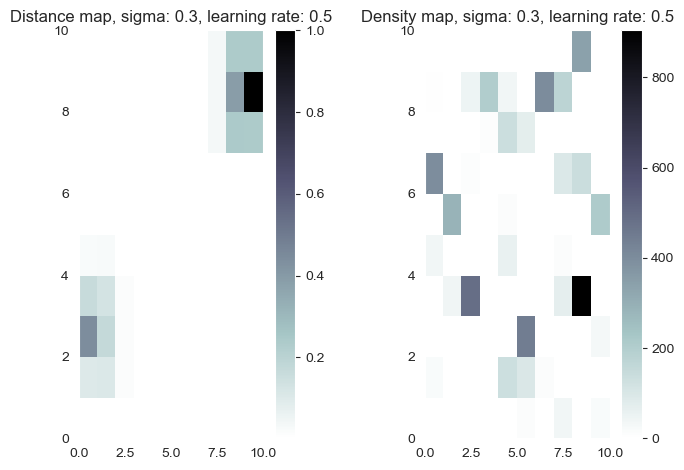

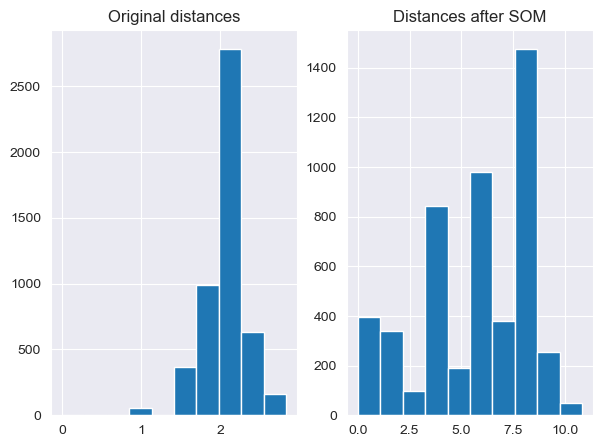

In [8]:
exp_inst = explainer_lime.explain_instance(X_test[0], model.predict_proba, som_model, num_features=7, plot=True, experiment=1)
exp_inst.show_in_notebook()
df1 = Lime_eval.evaluate_stability(X_test[0], model.predict_proba, explainer_lime, som_model, sample_size, experiment=1)

# Experiment 2
Distance between centroids + euclidean distance 


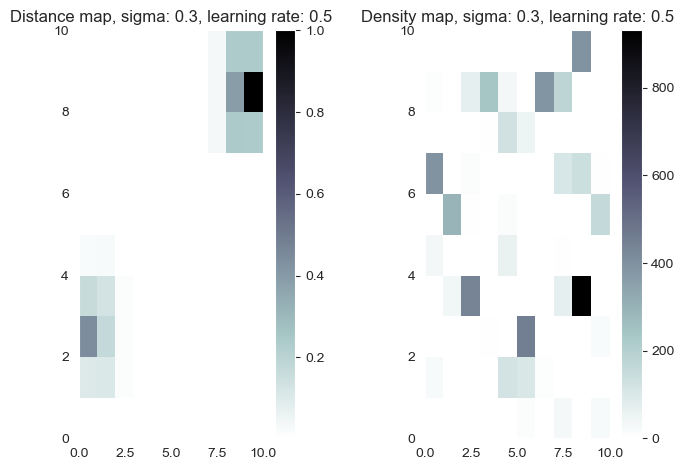

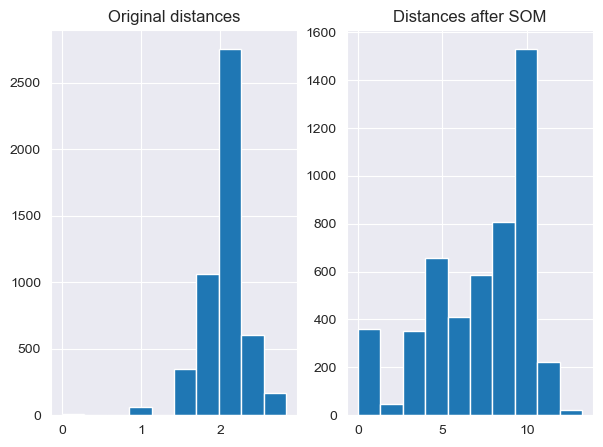

In [9]:
exp_inst = explainer_lime.explain_instance(X_test[0], model.predict_proba, som_model, num_features=7, plot=True, experiment=2)
exp_inst.show_in_notebook()
df2 = Lime_eval.evaluate_stability(X_test[0], model.predict_proba, explainer_lime, som_model, sample_size, experiment=2)

# Experiment 3

Euclidean distance for instances in the same cluster of instances to explain, 10 is for istances that are out of cluster 



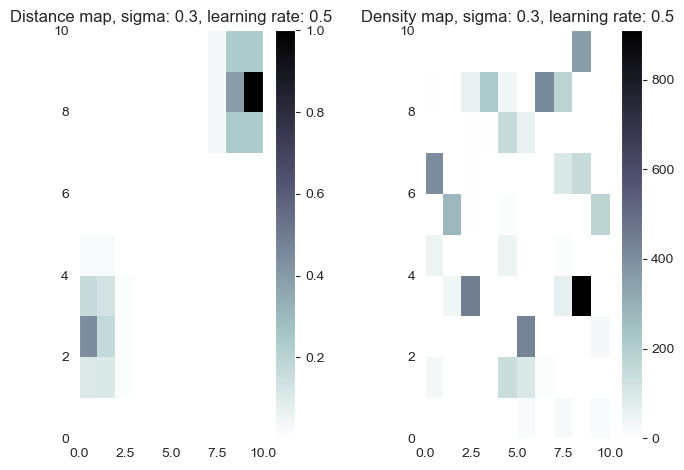

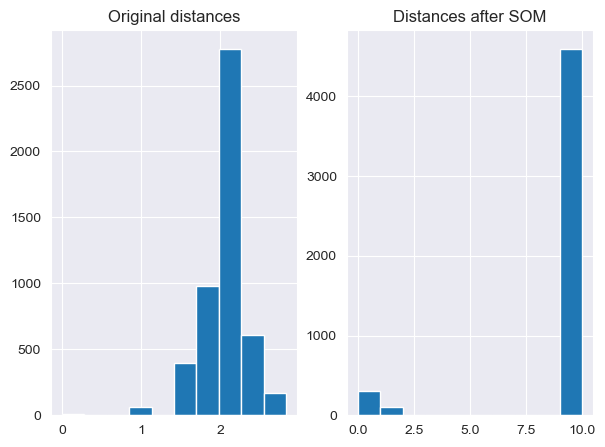

In [10]:
exp_inst = explainer_lime.explain_instance(X_test[0], model.predict_proba, som_model, num_features=7, plot=True, experiment=3)
exp_inst.show_in_notebook()
df3 = Lime_eval.evaluate_stability(X_test[0], model.predict_proba, explainer_lime, som_model, sample_size, experiment=3)

In [11]:
Lime_eval.compare_experiments(df0, df1, all=True, mean=True)

Experiment 0 all columns:
-------------------------
Significant Results:
race <= 0.00                        F-statistic = 418.2811   p-value = 0.000000   Variance is HIGHER in modified experiment

Non-Significant Results:
0.00 < c_charge_degree_F <= 1.00    F-statistic = nan        p-value = nan        Variance is HIGHER in modified experiment
0.00 < two_year_recid <= 1.00       F-statistic = nan        p-value = nan        Variance is HIGHER in modified experiment
1.00 < length_of_stay <= 5.00       F-statistic = nan        p-value = nan        Variance is HIGHER in modified experiment
31.00 < age <= 42.00                F-statistic = nan        p-value = nan        Variance is HIGHER in modified experiment
c_charge_degree_M <= 0.00           F-statistic = nan        p-value = nan        Variance is HIGHER in modified experiment
priors_count <= 0.00                F-statistic = nan        p-value = nan        Variance is HIGHER in modified experiment
sex_Female <= 0.00               

In [12]:
Lime_eval.compare_experiments(df0, df2, all=True, mean=True)

Experiment 0 all columns:
-------------------------
Significant Results:
31.00 < age <= 42.00                F-statistic = 251.8727   p-value = 0.000000   Variance is HIGHER in modified experiment
priors_count <= 0.00                F-statistic = 23.8205    p-value = 0.000004   Variance is HIGHER in modified experiment
race <= 0.00                        F-statistic = 253.7050   p-value = 0.000000   Variance is HIGHER in modified experiment

Non-Significant Results:
0.00 < c_charge_degree_F <= 1.00    F-statistic = nan        p-value = nan        Variance is HIGHER in modified experiment
0.00 < two_year_recid <= 1.00       F-statistic = nan        p-value = nan        Variance is HIGHER in modified experiment
1.00 < length_of_stay <= 5.00       F-statistic = nan        p-value = nan        Variance is HIGHER in modified experiment
c_charge_degree_M <= 0.00           F-statistic = nan        p-value = nan        Variance is HIGHER in modified experiment
sex_Female <= 0.00               

In [13]:
Lime_eval.compare_experiments(df0, df3, all=True, mean=True)

Experiment 0 all columns:
-------------------------
Significant Results:
priors_count <= 0.00                F-statistic = 16.0580    p-value = 0.000120   Variance is HIGHER in modified experiment
race <= 0.00                        F-statistic = 384.4050   p-value = 0.000000   Variance is HIGHER in modified experiment

Non-Significant Results:
0.00 < c_charge_degree_F <= 1.00    F-statistic = nan        p-value = nan        Variance is HIGHER in modified experiment
0.00 < two_year_recid <= 1.00       F-statistic = nan        p-value = nan        Variance is HIGHER in modified experiment
1.00 < length_of_stay <= 5.00       F-statistic = nan        p-value = nan        Variance is HIGHER in modified experiment
31.00 < age <= 42.00                F-statistic = nan        p-value = nan        Variance is HIGHER in modified experiment
c_charge_degree_M <= 0.00           F-statistic = nan        p-value = nan        Variance is HIGHER in modified experiment
sex_Female <= 0.00               